In [1]:
# Replace with your actual repo URL
!git clone https://github.com/VassilisK2001/Grecotel-Project.git

Cloning into 'Grecotel-Project'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 130 (delta 0), reused 2 (delta 0), pack-reused 125 (from 1)
Receiving objects: 100% (130/130), 36.79 MiB | 13.57 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Updating files: 100% (45/45), done.
Filtering content: 100% (2/2), 255.43 MiB | 16.52 MiB/s, done.


In [2]:
# ==========================================
# 1. INSTALL DEPENDENCIES
# ==========================================
%pip install -q transformers datasets scikit-learn accelerate seaborn iterative-stratification

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch.utils.data import Dataset
from torch import nn
from transformers import (
    LongformerTokenizer, 
    LongformerForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)

In [4]:
# ==========================================
# 2. CONFIGURATION & DATA PREPARATION
# ==========================================
# Set file path
DATA_FILE = "Grecotel-Project/absa/labeled_hotel_reviews_full.json" 

def load_and_preprocess_data(filepath):
    print("Loading and preprocessing data...")
    df = pd.read_json(filepath)
    
    # 1. Create Combined Label (Aspect + Sentiment)
    # Example: "FOOD" + "positive" -> "FOOD_positive"
    df['combined_label'] = df['aspect'] + '_' + df['sentiment']
    
    # 2. Remove rows with missing aspects if any
    df = df.dropna(subset=['aspect'])

    # 3. Pivot to Wide Format (One row per review, list of labels)
    grouped = df.groupby(['id', 'review_text'])['combined_label'].apply(list).reset_index()
    
    # 4. Multi-Hot Encoding
    mlb = MultiLabelBinarizer()
    binary_labels = mlb.fit_transform(grouped['combined_label'])
    
    # Create final dataframe
    final_df = grouped[['review_text']].copy()
    final_df['labels'] = list(binary_labels)
    
    print(f"Processed {len(final_df)} unique reviews.")
    print(f"Detected {len(mlb.classes_)} unique classes: {mlb.classes_}")
    
    return final_df, mlb

In [5]:
# Load Data
df, mlb = load_and_preprocess_data(DATA_FILE)

Loading and preprocessing data...
Processed 11961 unique reviews.
Detected 16 unique classes: ['CLEANLINESS_negative' 'CLEANLINESS_positive' 'COMFORT_negative'
 'COMFORT_positive' 'FACILITIES_negative' 'FACILITIES_positive'
 'FOOD_negative' 'FOOD_positive' 'LOCATION_negative' 'LOCATION_positive'
 'ROOM_negative' 'ROOM_positive' 'SERVICE_negative' 'SERVICE_positive'
 'VALUE_FOR_MONEY_negative' 'VALUE_FOR_MONEY_positive']


In [6]:
# ==========================================
# 3. STRATIFIED SPLIT (Train / Val / Test)
# ==========================================
print("\nSplitting dataset (80% Train, 10% Val, 10% Test)...")

X = df['review_text'].to_numpy()
y = np.array(df['labels'].tolist())

# Split 1: Separate Test Set (10%)
msss_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in msss_test.split(X, y):
    X_train_val, X_test = X[train_index], X[test_index]
    y_train_val, y_test = y[train_index], y[test_index]

# Split 2: Separate Train (80%) and Val (10%) from the remaining 90%
# 0.11 of 90% is approx 10% of total
msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.11, random_state=42)
for train_index, val_index in msss_val.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]

# Helper to convert back to DataFrame
def to_df(texts, labels):
    return pd.DataFrame({'review_text': texts, 'labels': list(labels)})

train_df = to_df(X_train, y_train)
val_df = to_df(X_val, y_val)
test_df = to_df(X_test, y_test)

print(f"Train Size: {len(train_df)} | Val Size: {len(val_df)} | Test Size: {len(test_df)}")


Splitting dataset (80% Train, 10% Val, 10% Test)...
Train Size: 9575 | Val Size: 1182 | Test Size: 1204


In [7]:
# ==========================================
# 4. CUSTOM DATASET & TOKENIZER
# ==========================================
class LongformerABSA_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=4096):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]['review_text'])
        labels = self.data.iloc[index]['labels']

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        # --- GLOBAL ATTENTION MASK (CRITICAL FOR LONGFORMER) ---
        # 1 = Global Attention (Look at everything), 0 = Local Attention
        # We put Global Attention ONLY on the [CLS] token (first token)
        global_attention_mask = torch.zeros_like(input_ids)
        global_attention_mask[0] = 1 

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'global_attention_mask': global_attention_mask, 
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Initialize Tokenizer
print("\nInitializing Longformer Tokenizer...")
model_name = 'allenai/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(model_name)

# Create Datasets
train_dataset = LongformerABSA_Dataset(train_df, tokenizer)
val_dataset = LongformerABSA_Dataset(val_df, tokenizer)
test_dataset = LongformerABSA_Dataset(test_df, tokenizer)


Initializing Longformer Tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [8]:
# ==========================================
# 5. MODEL SETUP & METRICS
# ==========================================
# Create ID maps
id2label = {i: label for i, label in enumerate(mlb.classes_)}
label2id = {label: i for i, label in enumerate(mlb.classes_)}

print("Loading Model...")
model = LongformerForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def compute_metrics(p):
    predictions, labels = p
    # Sigmoid to get 0-1 probabilities
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # Threshold at 0.5
    y_pred = np.zeros(probs.shape)
    y_pred[probs >= 0.5] = 1
    
    f1_micro = f1_score(y_true=labels, y_pred=y_pred, average='micro')
    return {'f1_micro': f1_micro}

Loading Model...


pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

In [ ]:
# ==========================================
# 6. TRAINING (A100 OPTIMIZED)
# ==========================================

training_args = TrainingArguments(
    output_dir="/content/longformer_output",
    
    # --- A100 POWER SETTINGS ---
    per_device_train_batch_size=4,       # INCREASED: A100 can handle ~4 samples (w/ checkpointing)
    per_device_eval_batch_size=4,        # INCREASED: Faster evaluation
    gradient_accumulation_steps=4,       # DECREASED: 4 batch * 4 accum = 16 effective batch size
    
    gradient_checkpointing=True,         # KEEP TRUE: Still needed for Longformer with 4096 tokens
    fp16=False,                          # Turn OFF fp16
    bf16=True,                           # Turn ON bf16 (A100 specific feature - more stable)
    
    dataloader_num_workers=4,            # Feed data faster to the GPU
    # ---------------------------

    # Best Model Strategy (Unchanged)
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    save_total_limit=2,

    num_train_epochs=5,
    learning_rate=3e-5, 
    warmup_ratio=0.1,
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("\nStarting Training on A100...")
trainer.train()

trainer.save_model("/content/longformer_output")

/tmp/ipython-input-2606432086.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting Training on A100...


Epoch,Training Loss,Validation Loss,F1 Micro
1,0.312900,0.296006,0.805758
2,0.253000,0.245450,0.834757
3,0.202300,0.225245,0.846290
4,0.176600,0.216169,0.853423
5,0.152700,0.213790,0.859296


TrainOutput(global_step=2995, training_loss=0.239800873344052, metrics={'train_runtime': 9987.3628, 'train_samples_per_second': 4.794, 'train_steps_per_second': 0.3, 'total_flos': 1.25799750647808e+17, 'train_loss': 0.239800873344052, 'epoch': 5.0})

In [19]:
# ==========================================
# 7. EVALUATION ON TEST SET
# ==========================================
print("\nRunning Evaluation on Test Set...")

predictions_output = trainer.predict(test_dataset)
raw_logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert Logits -> Probs -> Binary Predictions
probs = torch.sigmoid(torch.tensor(raw_logits)).numpy()
y_pred = (probs >= 0.5).astype(int)

# Generate Report
report = classification_report(
    true_labels, 
    y_pred, 
    target_names=mlb.classes_, 
    zero_division=0
)
print("\n--- CLASSIFICATION REPORT ---")
print(report)


Running Evaluation on Test Set...



--- CLASSIFICATION REPORT ---
                          precision    recall  f1-score   support

    CLEANLINESS_negative       0.77      0.60      0.67       141
    CLEANLINESS_positive       0.90      0.93      0.91       399
        COMFORT_negative       0.74      0.68      0.70       210
        COMFORT_positive       0.82      0.71      0.76       381
     FACILITIES_negative       0.76      0.70      0.73       211
     FACILITIES_positive       0.85      0.89      0.87       638
           FOOD_negative       0.82      0.77      0.79       145
           FOOD_positive       0.96      0.97      0.97       861
       LOCATION_negative       0.70      0.56      0.63       110
       LOCATION_positive       0.89      0.92      0.91       735
           ROOM_negative       0.82      0.80      0.81       186
           ROOM_positive       0.80      0.88      0.84       468
        SERVICE_negative       0.82      0.82      0.82       174
        SERVICE_positive       0.97      0.9


Generating Co-occurrence Heatmap...


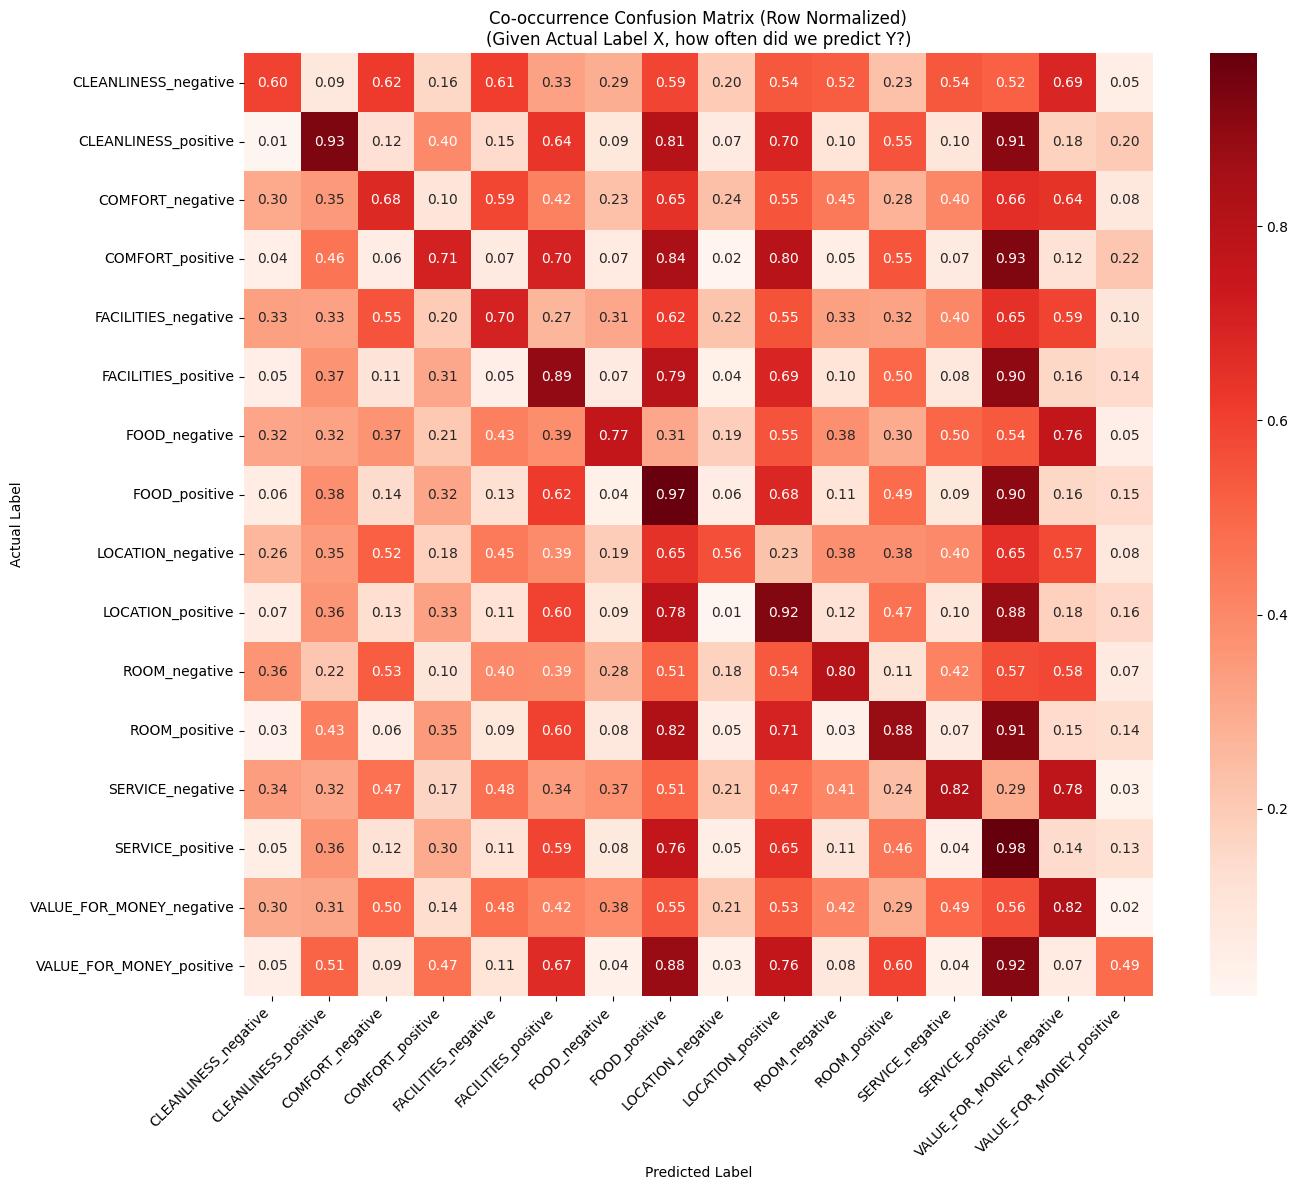

In [20]:
# ==========================================
# 8. PLOT CO-OCCURRENCE HEATMAP
# ==========================================
print("\nGenerating Co-occurrence Heatmap...")

# Calculate intersection: (Actual Label) vs (Predicted Label)
confusion_cooccurrence = np.dot(true_labels.T, y_pred)

# Normalize by row sum (Actual count) to get percentages
row_sums = true_labels.sum(axis=0)
row_sums[row_sums == 0] = 1 # avoid div by zero
norm_conf_matrix = confusion_cooccurrence / row_sums[:, None]

plt.figure(figsize=(14, 12))
sns.heatmap(
    norm_conf_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='Reds',
    xticklabels=mlb.classes_,
    yticklabels=mlb.classes_
)
plt.title("Co-occurrence Confusion Matrix (Row Normalized)\n(Given Actual Label X, how often did we predict Y?)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:

class AspectSentimentAnalyzer:
    def __init__(self, model_path):
        """
        Load the model and tokenizer once when the class is initialized.
        """
        print(f"Loading model from {model_path}...")
        self.tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
        self.model = LongformerForSequenceClassification.from_pretrained(model_path)
        self.model.eval()  # Set to evaluation mode
        
        # Define Custom Thresholds to fix your "Weaknesses"
        # Standard is 0.5. We lower it for 'Recall' and raise it for 'Precision'.
        self.thresholds = {
            'VALUE_FOR_MONEY_positive': 0.30,  # Lowered to catch more "Value" comments
            'VALUE_FOR_MONEY_negative': 0.30,
            'LOCATION_negative': 0.35,         # Lowered to catch location complaints
            'default': 0.50                    # Standard for everything else (Service, Food, etc.)
        }

    def predict(self, text):
        """
        Analyzes a single review and returns active labels.
        """
        # 1. Tokenize (Dynamic Padding for CPU speed)
        # We do NOT use padding='max_length' here to keep it fast
        inputs = self.tokenizer(
            text, 
            return_tensors="pt", 
            truncation=True, 
            max_length=4096
        )

        # 2. Create Global Attention Mask
        # (Longformer needs to know which token is global. usually [CLS] at index 0)
        global_attention_mask = torch.zeros_like(inputs["input_ids"])
        global_attention_mask[:, 0] = 1
        inputs["global_attention_mask"] = global_attention_mask

        # 3. Inference
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            
        # 4. Convert Logits to Probabilities (Sigmoid)
        probs = torch.sigmoid(logits).numpy()[0]
        
        # 5. Apply Custom Thresholds
        results = {}
        id2label = self.model.config.id2label
        
        for idx, score in enumerate(probs):
            label_name = id2label[idx]
            
            # Determine which threshold to use
            threshold = self.thresholds.get(label_name, self.thresholds['default'])
            
            # If score is higher than that label's specific threshold, keep it
            if score > threshold:
                results[label_name] = float(score)
        
        return results

# ==========================================
# HOW TO USE IT
# ==========================================

# 1. Initialize (Run this once)
# Ensure this points to your unzipped folder
model_path = "/content/longformer_output" 
analyzer = AspectSentimentAnalyzer(model_path)

# 2. Test a sample review
sample_review = """
The food was absolutely delicious and the staff was very friendly.
However, I felt it was a bit expensive for what we got, and the location was hard to find.
"""

print(f"\nReview: {sample_review.strip()}\n")
predictions = analyzer.predict(sample_review)

print("Detected Sentiments:")
for label, score in predictions.items():
    print(f"- {label}: {score:.4f}")

Loading model from /content/longformer_output...


Input ids are automatically padded to be a multiple of `config.attention_window`: 512



Review: The food was absolutely delicious and the staff was very friendly.
However, I felt it was a bit expensive for what we got, and the location was hard to find.

Detected Sentiments:
- FOOD_positive: 0.8865
- LOCATION_negative: 0.8496
- SERVICE_positive: 0.9745
- VALUE_FOR_MONEY_negative: 0.5907


### In order to improve the model we perform the following:     
* Retrain the model with fewer epochs to prevent overfitting
* Use weighted loss to handle class imbalance

In [9]:

def get_class_weights(df, class_names):
    """
    Calculates positive class weights for weighted loss training.
    
    Args:
        df (pd.DataFrame): DataFrame containing a 'labels' column (list of 0s/1s).
        class_names (list): List of label names (e.g., mlb.classes_) for display.
        
    Returns:
        torch.Tensor: Tensor of weights to pass to the Trainer.
    """
    print("--- Calculating Class Weights ---")
    
    # 1. Stack the list of lists into a 2D numpy matrix
    # Shape: (Num_Samples, Num_Classes)
    labels_matrix = np.vstack(df['labels'].values)
    
    # 2. Count Positives and Negatives per class
    pos_counts = labels_matrix.sum(axis=0)
    total_samples = labels_matrix.shape[0]
    neg_counts = total_samples - pos_counts
    
    # 3. Calculate Weight Ratio: Negatives / Positives
    # We use np.maximum(..., 1) to avoid dividing by zero if a class has 0 samples
    weights_array = neg_counts / np.maximum(pos_counts, 1)
    
    # 4. Print the results for inspection
    for idx, name in enumerate(class_names):
        print(f"Label: {name:<30} | Weight: {weights_array[idx]:.2f} (Pos: {pos_counts[idx]})")

    # 5. Return as PyTorch Tensor
    return torch.tensor(weights_array, dtype=torch.float)

# ==========================================
# USAGE
# ==========================================
# Run this using your existing 'df' and 'mlb' variables
pos_weights = get_class_weights(df, mlb.classes_)

print("\n✅ Weights calculated and ready for training.")

--- Calculating Class Weights ---
Label: CLEANLINESS_negative           | Weight: 7.52 (Pos: 1404)
Label: CLEANLINESS_positive           | Weight: 2.00 (Pos: 3991)
Label: COMFORT_negative               | Weight: 4.69 (Pos: 2101)
Label: COMFORT_positive               | Weight: 2.14 (Pos: 3808)
Label: FACILITIES_negative            | Weight: 4.66 (Pos: 2112)
Label: FACILITIES_positive            | Weight: 0.88 (Pos: 6379)
Label: FOOD_negative                  | Weight: 7.25 (Pos: 1449)
Label: FOOD_positive                  | Weight: 0.39 (Pos: 8605)
Label: LOCATION_negative              | Weight: 9.85 (Pos: 1102)
Label: LOCATION_positive              | Weight: 0.63 (Pos: 7348)
Label: ROOM_negative                  | Weight: 5.43 (Pos: 1859)
Label: ROOM_positive                  | Weight: 1.56 (Pos: 4676)
Label: SERVICE_negative               | Weight: 5.87 (Pos: 1740)
Label: SERVICE_positive               | Weight: 0.19 (Pos: 10090)
Label: VALUE_FOR_MONEY_negative       | Weight: 3.69 (P

In [10]:

class WeightedTrainer(Trainer):
    def __init__(self, pos_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Store weights to move them to the correct GPU device later
        self.pos_weights = pos_weights
    
    # We override the loss function
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Move weights to the same device as the model (GPU)
        weights = self.pos_weights.to(model.device)
        
        # Binary Cross Entropy with Weighted Classes
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=weights)
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [11]:
# 1. Reload the RAW Model (Reset weights)
model = LongformerForSequenceClassification.from_pretrained(
    'allenai/longformer-base-4096',
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)

# 2. Define Arguments (Optimized for A100 + Short Run)
training_args = TrainingArguments(
    output_dir="/content/longformer_output_weighted",
    per_device_train_batch_size=4,   # A100 batch size
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,   # Effective batch = 16
    gradient_checkpointing=True,
    bf16=True,                       # Use BF16 on A100
    dataloader_num_workers=4,
    
    num_train_epochs=3,              # Reduced to 3 Epochs
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    save_total_limit=2,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    logging_steps=50,
    report_to="none"
)

# 3. Initialize Weighted Trainer
trainer = WeightedTrainer(
    pos_weights=pos_weights,         # <--- Pass our new weights here
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 4. Train
print("Starting Weighted Training...")
trainer.train()

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2442459591.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Starting Weighted Training...


Epoch,Training Loss,Validation Loss,F1 Micro
1,0.519400,0.501403,0.706179
2,0.428900,0.425106,0.782120
3,0.342700,0.407736,0.793688


TrainOutput(global_step=1797, training_loss=0.48932184719283117, metrics={'train_runtime': 6256.5234, 'train_samples_per_second': 4.591, 'train_steps_per_second': 0.287, 'total_flos': 7.54798503886848e+16, 'train_loss': 0.48932184719283117, 'epoch': 3.0})

In [12]:
# ==========================================
# 1. GENERATE PREDICTIONS ON TEST SET
# ==========================================
print("Running inference on Test Set...")
predictions_output = trainer.predict(test_dataset)

# Extract Logits and True Labels
logits = predictions_output.predictions
y_true = predictions_output.label_ids

# Convert Logits to Probabilities (Sigmoid) & Binary Predictions (Threshold 0.5)
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.tensor(logits)).numpy()
y_pred = np.zeros(probs.shape)
y_pred[probs >= 0.5] = 1

# ==========================================
# 2. PRINT CLASSIFICATION REPORT
# ==========================================
print("\n--- CLASSIFICATION REPORT ---\n")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=mlb.classes_, 
    zero_division=0
))

Running inference on Test Set...



--- CLASSIFICATION REPORT ---

                          precision    recall  f1-score   support

    CLEANLINESS_negative       0.52      0.89      0.66       141
    CLEANLINESS_positive       0.88      0.95      0.92       399
        COMFORT_negative       0.57      0.92      0.70       210
        COMFORT_positive       0.73      0.81      0.77       381
     FACILITIES_negative       0.55      0.88      0.68       211
     FACILITIES_positive       0.77      0.74      0.76       638
           FOOD_negative       0.61      0.92      0.74       145
           FOOD_positive       0.90      0.76      0.82       861
       LOCATION_negative       0.45      0.85      0.59       110
       LOCATION_positive       0.82      0.78      0.80       735
           ROOM_negative       0.64      0.95      0.77       186
           ROOM_positive       0.76      0.94      0.84       468
        SERVICE_negative       0.65      0.94      0.77       174
        SERVICE_positive       0.95      0.

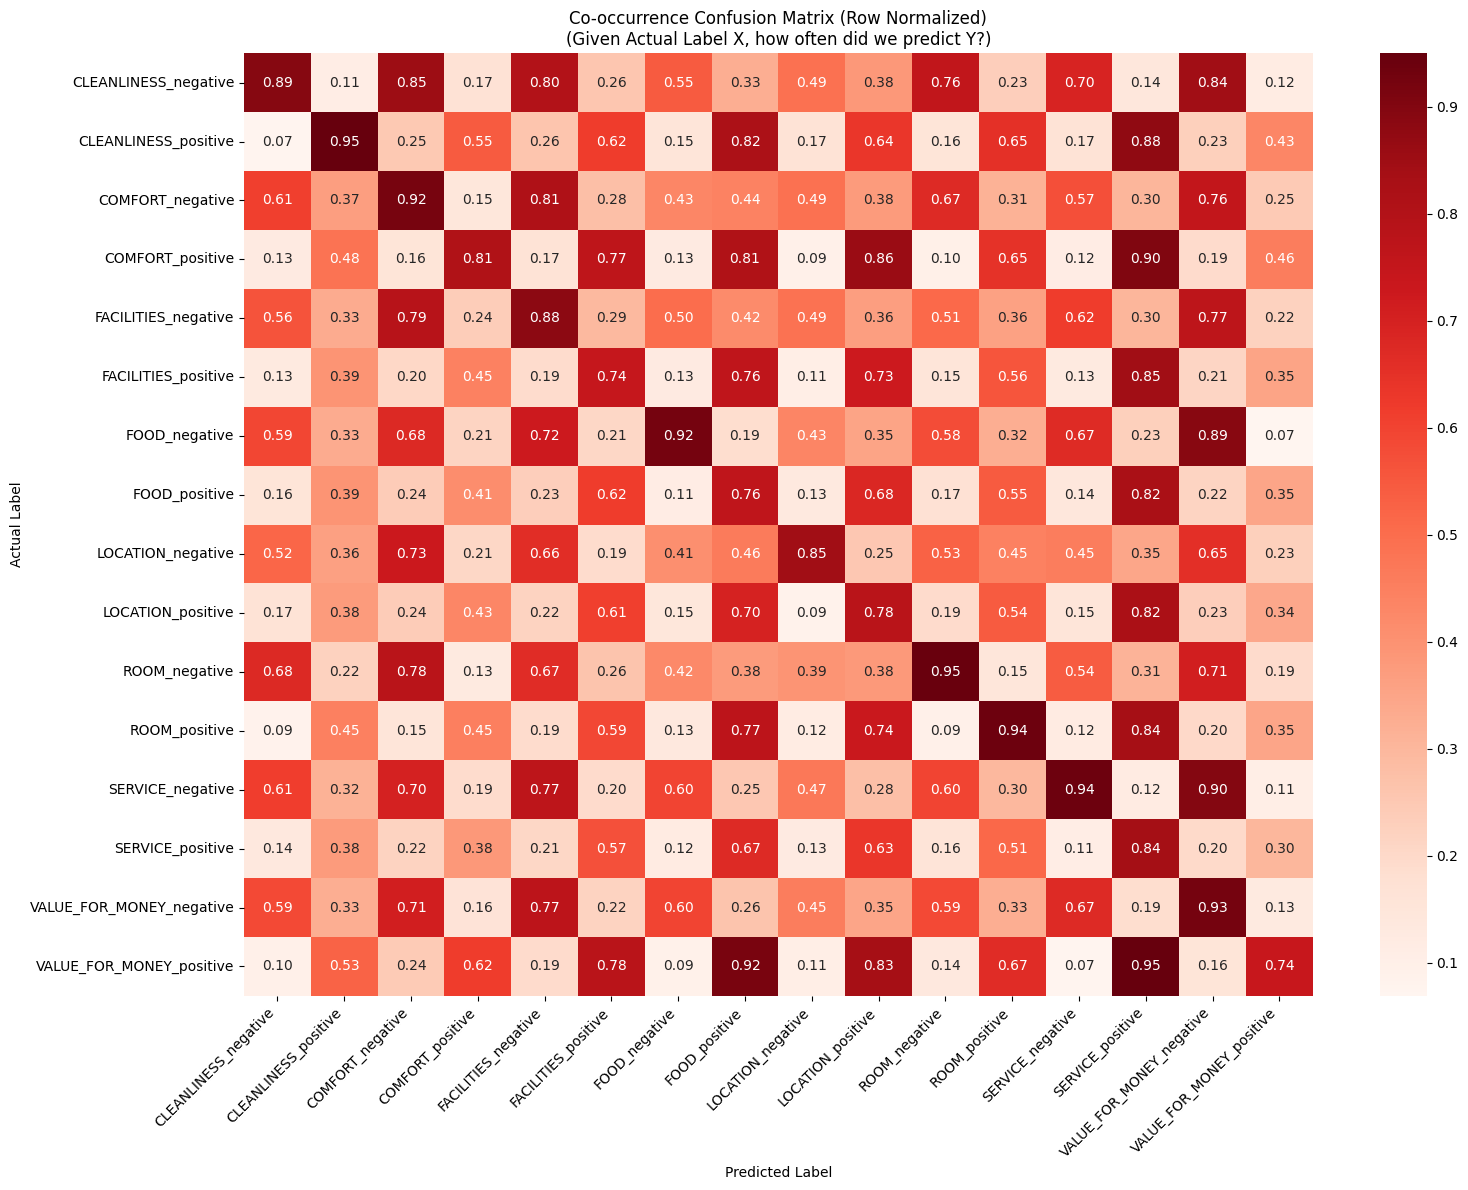

In [13]:
# ==========================================
# 3. PLOT CO-OCCURRENCE CONFUSION MATRIX
# ==========================================
# Logic: "Given that the review ACTUALLY has Label A (Row), 
# how often did the model predict Label B (Column)?"

# Initialize matrix
num_classes = len(mlb.classes_)
co_occurrence_matrix = np.zeros((num_classes, num_classes))

# Calculate counts
for i in range(num_classes): # Loop through ACTUAL labels (Rows)
    # Get indices where this label is actually present
    true_indices = np.where(y_true[:, i] == 1)[0]
    
    if len(true_indices) > 0:
        # For these specific examples, sum up the PREDICTIONS for all columns
        # This tells us: When Label 'i' is True, how often is Label 'j' predicted?
        co_occurrence_matrix[i, :] = y_pred[true_indices].sum(axis=0)
        
        # Normalize by the total count of the Actual Label 'i'
        # to get percentages (0.0 to 1.0)
        co_occurrence_matrix[i, :] = co_occurrence_matrix[i, :] / len(true_indices)

# Plotting
plt.figure(figsize=(16, 12))
sns.heatmap(
    co_occurrence_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='Reds',
    xticklabels=mlb.classes_,
    yticklabels=mlb.classes_
)

plt.title('Co-occurrence Confusion Matrix (Row Normalized)\n(Given Actual Label X, how often did we predict Y?)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
import shutil
import os

# 1. Define the folder you want to download
# (Make sure this matches the 'output_dir' you used in your TrainingArguments)
folder_to_download = "/content/longformer_output_weighted" 

# 2. Define the output zip filename (without .zip extension)
zip_filename = "/content/model_backup"

print(f"Zipping folder: {folder_to_download} ...")

# 3. Create the Zip file
shutil.make_archive(zip_filename, 'zip', folder_to_download)

print(f"Success! Created: {zip_filename}.zip")
print(f"File size: {os.path.getsize(zip_filename + '.zip') / (1024*1024):.2f} MB")

Zipping folder: /content/longformer_output_weighted ...
Success! Created: /content/model_backup.zip
File size: 2792.90 MB


In [17]:
import requests
import os

# 1. Define file path
file_path = "/content/model_backup.zip"

def upload_to_gofile(path):
    print(f"🚀 Uploading {path} to Gofile.io...")
    print("This can take 2-4 minutes depending on Google's speed. Please wait...")
    
    try:
        # A. Get the best server for upload
        server_request = requests.get("https://api.gofile.io/servers")
        server_data = server_request.json()
        
        if server_data['status'] != 'ok':
            return f"Error getting server: {server_data}"
            
        server = server_data['data']['servers'][0]['name']
        print(f"Connected to server: {server}")

        # B. Upload the file
        with open(path, "rb") as f:
            upload_url = f"https://{server}.gofile.io/uploadFile"
            response = requests.post(upload_url, files={'file': f}).json()
            
        if response['status'] == 'ok':
            return response['data']['downloadPage']
        else:
            return f"Upload Failed: {response}"
            
    except Exception as e:
        return f"Error: {e}"

# 2. Run and Print Link
if os.path.exists(file_path):
    link = upload_to_gofile(file_path)
    print("\n" + "="*50)
    print("✅ DOWNLOAD LINK IS HERE:")
    print(link)
    print("="*50)
else:
    print("❌ Error: /content/model_backup.zip does not exist. Did you run the zip step?")

🚀 Uploading /content/model_backup.zip to Gofile.io...
This can take 2-4 minutes depending on Google's speed. Please wait...
Connected to server: store10

✅ DOWNLOAD LINK IS HERE:
https://gofile.io/d/WcxV9d


In [19]:

# ==========================================
# 1. LOAD THE FINE-TUNED MODEL
# ==========================================
def load_finetuned_model(base_path):
    """
    Locates the latest checkpoint in the output directory and loads the model.
    """
    # 1. Find the subdirectory with the highest checkpoint number
    # (Trainer saves models in folders like 'checkpoint-500', 'checkpoint-1000')
    subfolders = [f.path for f in os.scandir(base_path) if f.is_dir() and "checkpoint" in f.name]
    
    if not subfolders:
        # If no checkpoints, maybe the model is in the root base_path?
        print(f"⚠️ No 'checkpoint-XXX' folders found in {base_path}. Trying root folder...")
        model_path = base_path
    else:
        # Sort by number (checkpoint-1000 > checkpoint-500)
        latest_checkpoint = max(subfolders, key=lambda x: int(x.split("-")[-1]))
        print(f"✅ Found latest checkpoint: {latest_checkpoint}")
        model_path = latest_checkpoint

    # 2. Load Tokenizer & Model
    print("Loading model... (This may take a minute)")
    tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
    model = LongformerForSequenceClassification.from_pretrained(model_path)
    
    # 3. Move to GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    print(f"🚀 Model loaded successfully on {device}!")
    return model, tokenizer

# --- LOAD IT NOW ---
output_dir = "/content/longformer_output_weighted"
model, tokenizer = load_finetuned_model(output_dir)


# ==========================================
# 2. PREDICTION FUNCTION
# ==========================================
def predict_sentiment(review_text, model, tokenizer, threshold=0.5):
    device = model.device
    
    # Tokenize (Dynamic padding)
    inputs = tokenizer(
        review_text,
        return_tensors="pt",
        truncation=True,
        max_length=4096
    )
    
    # Create Global Attention Mask ([CLS] token)
    global_attention_mask = torch.zeros_like(inputs["input_ids"])
    global_attention_mask[:, 0] = 1
    inputs["global_attention_mask"] = global_attention_mask
    
    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    
    # Convert to Probabilities
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    
    # Parse Results
    results = []
    id2label = model.config.id2label
    
    for idx, score in enumerate(probs):
        if score > threshold:
            label_name = id2label[idx]
            
            # Split "FOOD_positive" -> Aspect: FOOD, Sentiment: positive
            if "_positive" in label_name:
                aspect = label_name.replace("_positive", "")
                sentiment = "Positive"
            elif "_negative" in label_name:
                aspect = label_name.replace("_negative", "")
                sentiment = "Negative"
            else:
                aspect = label_name
                sentiment = "Unknown"
            
            results.append({
                "aspect": aspect,
                "sentiment": sentiment,
                "confidence": float(score)
            })
            
    return results

# ==========================================
# 3. TEST IT
# ==========================================
sample_review = """
We stayed for 3 nights. The room was spacious but the air conditioner was very noisy.
The staff at the front desk were incredibly helpful and polite.
Prices for the drinks at the bar were ridiculous though.
However the breakfast buffet was excellent with a wide variety of options.
"""

print(f"📝 Review: {sample_review.strip()}\n")

predictions = predict_sentiment(sample_review, model, tokenizer)

print("🔍 Detected Aspects:")
if not predictions:
    print("   (No aspects detected)")
else:
    for p in predictions:
        icon = "✅" if p['sentiment'] == "Positive" else "❌"
        print(f"   {icon} {p['aspect']}: {p['sentiment']} ({p['confidence']:.2%})")

✅ Found latest checkpoint: /content/longformer_output_weighted/checkpoint-1797
Loading model... (This may take a minute)
🚀 Model loaded successfully on cuda!
📝 Review: We stayed for 3 nights. The room was spacious but the air conditioner was very noisy.
The staff at the front desk were incredibly helpful and polite.
Prices for the drinks at the bar were ridiculous though.
However the breakfast buffet was excellent with a wide variety of options.

🔍 Detected Aspects:
   ❌ COMFORT: Negative (57.30%)
   ❌ ROOM: Negative (65.30%)
   ❌ VALUE_FOR_MONEY: Negative (89.25%)
